# Heatmap Visualization (class activation maps, CAM)

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import argparse
import yaml
import os
import sys
import cv2
import time
from tqdm import tqdm
tqdm.monitor_interval = 0

from caffe2.proto import caffe2_pb2
from caffe2.python import (
    workspace,
    model_helper,
    core, brew,
    optimizer,
    net_drawer
)

from model_utils import (
    load_init_net,
    add_input, 
    add_model, 
    add_loss, 
    add_training_operators,
    add_accuracy,
)

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print("All imports done!")

All imports done!


# Helper functions

In [2]:
def parse_args(config_file):
    """
    parse config file
    """
    config_data = yaml.load(open(config_file).read())
    return config_data

In [3]:
def show_model_net(model):
    net_graph = net_drawer.GetPydotGraph(model.net, rankdir="TB")
    net_graph.write_svg("net_graph.svg")
    image = cv2.imread("net_graph.svg")
    cv2.imshow(image)

In [4]:
def restore_image(image, config):
    image = image.transpose(1, 2, 0)  # CHW->HWC
    image = image[...,::-1]  # BGR->RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image *= config['training_data']['input_transform']['std_per_channel']
    image += config['training_data']['input_transform']['mean_per_channel']
    image = image / 255
    return image

In [5]:
def build_visualization_model(config):
    # set device
    device_opt = caffe2_pb2.DeviceOption()
    if config['gpu_id'] is not None:
        device_opt.device_type = caffe2_pb2.CUDA
        device_opt.cuda_gpu_id = config['gpu_id']

    # build model
    with core.DeviceScope(device_opt):
        visualization_model = model_helper.ModelHelper(
            name = '{}_visualization_model'.format(config['name']),
            init_params=False,
        )
        data, label = add_input(visualization_model, config, is_test=True)
        pred = add_model(visualization_model, config, data, is_test=True)
        loss = add_loss(visualization_model, config, pred, label)
        add_accuracy(visualization_model)

    # init workspace for training net
    workspace.RunNetOnce(visualization_model.param_init_net)
    load_init_net(config['network']['init_net'], device_opt)
    workspace.CreateNet(visualization_model.net)
    
    return visualization_model

# Core methods

Start to visualize heatmap in model Bi-Attention


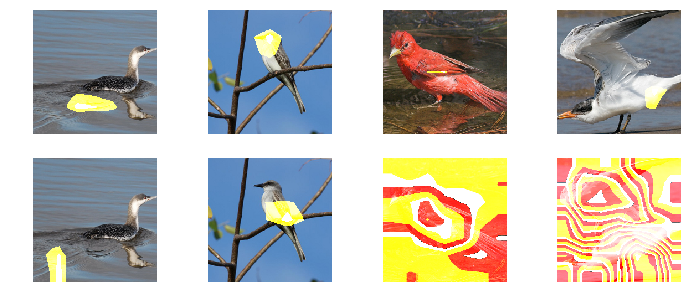

Done...


In [12]:
def heatmap_visualization(config):
    # run model for 1 iteration
    model = build_visualization_model(config)
    for i in range(3):
        workspace.RunNet(model.net)
    
    # get CAM
    images = workspace.FetchBlob('data')
    N, _, H, W = images.shape
    
    last_conv = workspace.FetchBlob('res5_2_branch2c') # N x 2048 x 7 x 7
    attention_1 = workspace.FetchBlob('attention_1') # N x 1024
    attention_2 = workspace.FetchBlob('attention_2') # N x 1024
    # softmax = workspace.FetchBlob('softmax') # N x 2048
    
    assert(last_conv.shape == (N, 2048, 7, 7)) # hard coded
    _, _, h, w = last_conv.shape
    
    cams_1 = np.zeros((N, h, w))
    cams_2 = np.zeros((N, h, w))
    total_dim = attention_1.shape[1]
    for i in range(N):
        for j, w in enumerate(attention_1[i][:]):
            cams_1[i] += w * last_conv[i][j, :, :]
        for j, w in enumerate(attention_2[i][:]):
#             cams_2[i] += w * last_conv[i][j + 1024, :, :]  # notice here!            
            cams_2[i] += w * last_conv[i][j, :, :]  # notice here!

    
    images_1 = list()
    images_2 = list()
    for i in range(N):
        cams1 = cams_1[i] / np.max(cams_1[i])
        cams1 = cv2.resize(cams1, (H, W))
#         heatmaps1 = cv2.applyColorMap(np.uint8(225 * cams1), cv2.COLORMAP_JET)
        heatmaps1 = cv2.applyColorMap(np.uint8(225 * cams1), cv2.COLORMAP_HOT)
        
#         heatmaps1[np.where(cams1 < 0.2)] = 0
        heatmaps1[np.where(cams1 < 0.7)] = 0        
        img1 = heatmaps1.transpose(2, 0, 1) * 0.5 + images[i]        
        images_1.append(img1)
        
        cams2 = cams_2[i] / np.max(cams_2[i])
        cams2 = cv2.resize(cams2, (H, W))
#         heatmaps2 = cv2.applyColorMap(np.uint8(225 * cams2), cv2.COLORMAP_JET)
        heatmaps2 = cv2.applyColorMap(np.uint8(225 * cams2), cv2.COLORMAP_HOT)
        
#         heatmaps2[np.where(cams2 < 0.2)] = 0
        heatmaps2[np.where(cams2 < 0.7)] = 0
        img2 = heatmaps2.transpose(2, 0, 1) * 0.5 + images[i]
        images_2.append(img2)

    for i in range(N):
        # show original image
        plt.subplot(2, N, i + 1)
        img1 = restore_image(images_1[i], config)
        plt.imshow(img1)
        plt.axis('off')
        
        # show saliency map
        plt.subplot(2, N, N + i + 1)
#         plt.imshow(saliency[i], cmap=plt.cm.hot)
        img2 = restore_image(images_2[i], config)
        plt.imshow(img2)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


# Running
config_file = "Bi-Attention_config.yaml"
config = parse_args(config_file)

print("Start to visualize heatmap in model {}".format(config['name']))
heatmap_visualization(config)
print("Done...")   